In [1]:
import __main__
print(__main__.__package__)

None


In [2]:
import sys
import os

sys.path.append(os.path.abspath("..")) 

In [3]:
from omegaconf import OmegaConf

gpu_config = {
    "seed": 42,
    "device": "cuda",
}

gpu_config = OmegaConf.create(gpu_config)

In [4]:
import torch
import numpy as np

torch.manual_seed(gpu_config.seed)
np.random.seed(gpu_config.seed)

if torch.cuda.is_available and 'cuda' in gpu_config.device:
    torch.cuda.manual_seed(gpu_config.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

os.environ['PYTHONASHSEED'] = str(gpu_config.seed)

In [5]:
dataloader_cfg = {
    "datasets": {
        "data_dir": "/home/cc/efficient-rsnn-bmi/data/datasets",
        "ratio_val": 0.1,
        "random_val": False,
        "extend_data": True,
        "sample_duration": 2.0,
        "remove_segments_inactive": False,
        "p_drop": 0.0,
        "p_insert": 0.0,
        "jitter_sigma": 0.0,
        "dtype": "float32",
        "dt": 4e-3,
    }
}

dataloader_cfg = OmegaConf.create(dataloader_cfg)

In [6]:
from efficient_rsnn_bmi.core.dataloader import get_dataloader

dtype = getattr(torch, dataloader_cfg.datasets.dtype)
dataloader = get_dataloader(dataloader_cfg, dtype=dtype)

In [ ]:
monkey_name = "indy"
monkey_files = {
    "indy": {
        "session01": "indy_20160622_01.mat",
        "session02": "indy_20160624_03.mat",
    }
}

In [8]:
filename = list(monkey_files[monkey_name].values())
filename

['indy_20160622_01.mat', 'indy_20160624_03.mat']

In [9]:
train_data, val_data, test_data = dataloader.get_multiple_sessions_data(filename)

Loading indy_20160622_01.mat
[2025-05-29 18:31:51] [INFO] [data.neurobench.dataloader] - Extending data...
Loading indy_20160624_03.mat
[2025-05-29 18:32:17] [INFO] [data.neurobench.dataloader] - Extending data...


In [10]:
print(f"Length of train data: {len(train_data)}")
print(f"Length of val data: {len(val_data)}")
print(f"Length of test data: {len(test_data)}")
print(f"Dimension of 1st spike train data: {(train_data[0][0].shape)}")
print(f"Dimension of 1st of label train data: {(train_data[0][1].shape)}")
print(f"Dimension of 1st spike val data: {(val_data[0][0].shape)}")
print(f"Dimension of 1st of label val data: {(val_data[0][1].shape)}")
print(f"Dimension of 1st spike test data: {(test_data[0][0][0].shape)}")
print(f"Dimension of 1st of label test data: {(test_data[0][0][1].shape)}")

Length of train data: 4722
Length of val data: 974
Length of test data: 2
Dimension of 1st spike train data: torch.Size([500, 96])
Dimension of 1st of label train data: torch.Size([500, 2])
Dimension of 1st spike val data: torch.Size([500, 96])
Dimension of 1st of label val data: torch.Size([500, 2])
Dimension of 1st spike test data: torch.Size([132745, 96])
Dimension of 1st of label test data: torch.Size([132745, 2])


In [11]:
print(f"Data type of 1st spike train data: {train_data[0][0].dtype}")
print(f"Data type of 1st label train data: {train_data[0][1].dtype}")
print(f"Data type of 1st spike val data: {val_data[0][0].dtype}")
print(f"Data type of 1st label val data: {val_data[0][1].dtype}")
print(f"Data type of 1st spike test data: {test_data[0][0][0].dtype}")
print(f"Data type of 1st label test data: {test_data[0][0][1].dtype}")

Data type of 1st spike train data: torch.float32
Data type of 1st label train data: torch.float32
Data type of 1st spike val data: torch.float32
Data type of 1st label val data: torch.float32
Data type of 1st spike test data: torch.float32
Data type of 1st label test data: torch.float32


In [12]:
nb_time_steps = int(dataloader_cfg.datasets.sample_duration / dataloader_cfg.datasets.dt)
nb_outputs = train_data[0][1].shape[1]
nb_inputs = train_data[0][0].shape[1]

print(f"Time Steps: {nb_time_steps}")
print(f"Input Channels: {nb_inputs}")
print(f"Output Channels: {nb_outputs}")

Time Steps: 500
Input Channels: 96
Output Channels: 2


In [13]:
training_config = {
    "training": {
        "batch_size": 250,
        "SG_beta": 20,
        "LB_L2_strength": 100,
        "LB_L2_thresh": 1e-3,
        "UB_L2_strength": 0.01,
        "UB_L2_thresh": 10,
    }
}
training_config = OmegaConf.create(training_config)

In [14]:
device = "cuda:0"

In [15]:
from efficient_rsnn_bmi.experiments.models.rsnn.rsnn_interpolate import InterpolateRecurrentSpikingModel

model = InterpolateRecurrentSpikingModel(
    batch_size = training_config.training.batch_size,
    nb_time_steps = nb_time_steps,
    nb_inputs = nb_inputs,
    device = device,
    dtype = dtype,
    n_keys=8
)

In [16]:
model_config = {
    "model": {
        "stochastic": False,
        "dropout_p": 0.3,
        "nb_hidden": 1,
        "hidden_size": [64],
        "recurrent": [True],
        "multiple_readout": False,
        "tau_mem_readout": 50e-3,
        "tau_syn_readout": 10e-3,
        "tau_mem": 20e-3,
        "tau_syn": 10e-3,
        "het_timescales": True,
        "het_timescales_readout": True,
        "learn_timescales": True,
        "learn_timescales_readout": True,
        "delta_synapse": False,
        "is_half": True,
        "key_step": 8,
    }
}

model_config = OmegaConf.create(model_config)

In [17]:
import stork

activation_function = stork.activations.CustomSpike

if model_config.model.stochastic:
    activation_function.escape_noise_type = "sigmoid"
else:
    activation_function.escape_noise_type = "step"

activation_function.escape_noise_params = {"beta": training_config.training.SG_beta}
activation_function.surrogate_type = "SuperSpike"
activation_function.surrogate_params = {"beta": training_config.training.SG_beta}

In [18]:
regs = []

regLB = stork.regularizers.LowerBoundL2(
    strength = training_config.training.LB_L2_strength,
    threshold = training_config.training.LB_L2_thresh,
    dims = False,
)

regUB = stork.regularizers.UpperBoundL2(
    strength = training_config.training.UB_L2_strength,
    threshold = training_config.training.UB_L2_thresh,
    dims = 1,
)

regs.append(regLB)
regs.append(regUB)

In [19]:
from efficient_rsnn_bmi.core.dataloader import compute_input_firing_rates

mean1, mean2 = compute_input_firing_rates(train_data, dataloader_cfg)

In [20]:
initializers_config = {
    "initializer": {
        "compute_nu": True,
        "sigma_u": 0.5,
        "nu": 20,
        "alpha": 0.9,
        "kaiming_gain": 1.0
    }
}

In [21]:
initializers_config = OmegaConf.create(initializers_config)

In [22]:
from stork.initializers import (
    FluctuationDrivenCenteredNormalInitializer,
    DistInitializer
)

hidden_init = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=initializers_config.initializer.sigma_u,
    nu=mean1,
    timestep=dataloader_cfg.datasets.dt,
    alpha=initializers_config.initializer.alpha,
    dtype=dtype,
)

readout_init = DistInitializer(
    dist=torch.distributions.Normal(0, 1),
    scaling="1/sqrt(k)",
    dtype=dtype,
)

In [23]:
# from stork.nodes import InputGroup
from stork.layers import Layer
from stork.connections import Connection
from efficient_rsnn_bmi.base.interpolation.inputs import InterpolationInputGroup
from efficient_rsnn_bmi.base.lif import CustomLIFGroup
from efficient_rsnn_bmi.base.readout import CustomReadoutGroup

input_group = model.add_group(
    InterpolationInputGroup(
        shape=nb_inputs,
        dropout_p=model_config.model.dropout_p,
    )
)
current_src_grp = input_group

In [24]:
current_src_grp = input_group
for i in range (model_config.model.nb_hidden):
    hidden_layer = Layer(
        name = f"hidden_{i}",
        model = model,
        size = model_config.model.hidden_size[i],
        input_group = input_group,
        recurrent = model_config.model.recurrent[i],
        regs = regs,
        neuron_class = CustomLIFGroup,
        neuron_kwargs={
            "tau_mem": model_config.model.tau_mem,
            "tau_syn": model_config.model.tau_syn,
            "activation": activation_function,
            "dropout_p": model_config.model.dropout_p,
            "het_timescales": model_config.model.het_timescales,
            "learn_timescales": model_config.model.learn_timescales,
            "is_delta_syn": model_config.model.delta_synapse,
        },
        connection_class=Connection,
        connection_kwargs={}
    )

    current_src_grp = hidden_layer.output_group
    print(current_src_grp)

    hidden_init.initialize(hidden_layer)

    if i == 0 and nb_inputs == 192 and train_data is not None:
        with torch.no_grad():
            hidden_layer.connections[0].weight[:, :96] /= mean2 / mean1
        
    # Add single RO group
    readout_group = model.add_group(
        CustomReadoutGroup(
            nb_outputs,
            tau_mem = model_config.model.tau_mem_readout,
            tau_syn = model_config.model.tau_syn_readout,
            het_timescales = model_config.model.het_timescales_readout,
            learn_timescales = model_config.model.learn_timescales_readout,
            initial_state = -1e-2,
            is_delta_syn = model_config.model.delta_synapse,
        )
    )

    print("Readout group shape: ", readout_group.shape)
    print("Current source group shape: ", current_src_grp.shape)
    print(current_src_grp, readout_group)
    con_ro = model.add_connection(
        Connection(current_src_grp, readout_group, dtype=dtype)
    )

    readout_init.initialize(con_ro)

CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
)
Readout group shape:  (2,)
Current source group shape:  (64,)
CustomLIFGroup(
  (dropout): Dropout(p=0.3, inplace=False)
) CustomReadoutGroup()


In [25]:
from efficient_rsnn_bmi.base.loss import RootMeanSquareError

loss_class = RootMeanSquareError()
# Mask Early Timestep later

In [26]:
from stork.optimizers import SMORMS3

opt_kwargs = {
    "lr": 2e-3
}

opt_kwargs["eps"] = 1e-5 if dtype == torch.float16 else 1e-16

opt = SMORMS3

In [27]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
scheduler_kwargs = {"T_max": 200} # nb of epoch train

In [28]:
# Make sure this later (Worker Init Seeding)

import numpy as np
import random

def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)

In [29]:
from stork.generators import StandardGenerator

generator = StandardGenerator(
    nb_workers=2,
    worker_init_fn=worker_init_fn,
)

In [30]:
model.configure(
    input=model.groups[0],
    output=model.groups[-1],
    loss_stack=loss_class,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=opt_kwargs,
    scheduler=scheduler,
    scheduler_kwargs=scheduler_kwargs,
    time_step=dataloader_cfg.datasets.dt,
)

In [31]:
model.summary()


# Model summary

## Groups
Input, (96,)
hidden_0, (64,)
Readout, (2,)

## Connections
Connection(
  (src): InterpolationInputGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=96, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)
Connection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomReadoutGroup()
  (op): Linear(in_features=64, out_features=2, bias=False)
)


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


This is the score [ 0.28154677  1.25257584 -0.00725    -0.05425    -0.03075   ]


/home/cc/efficient-rsnn-bmi/efficient_rsnn_bmi/utils/plotting.py:263: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0][-1].legend()


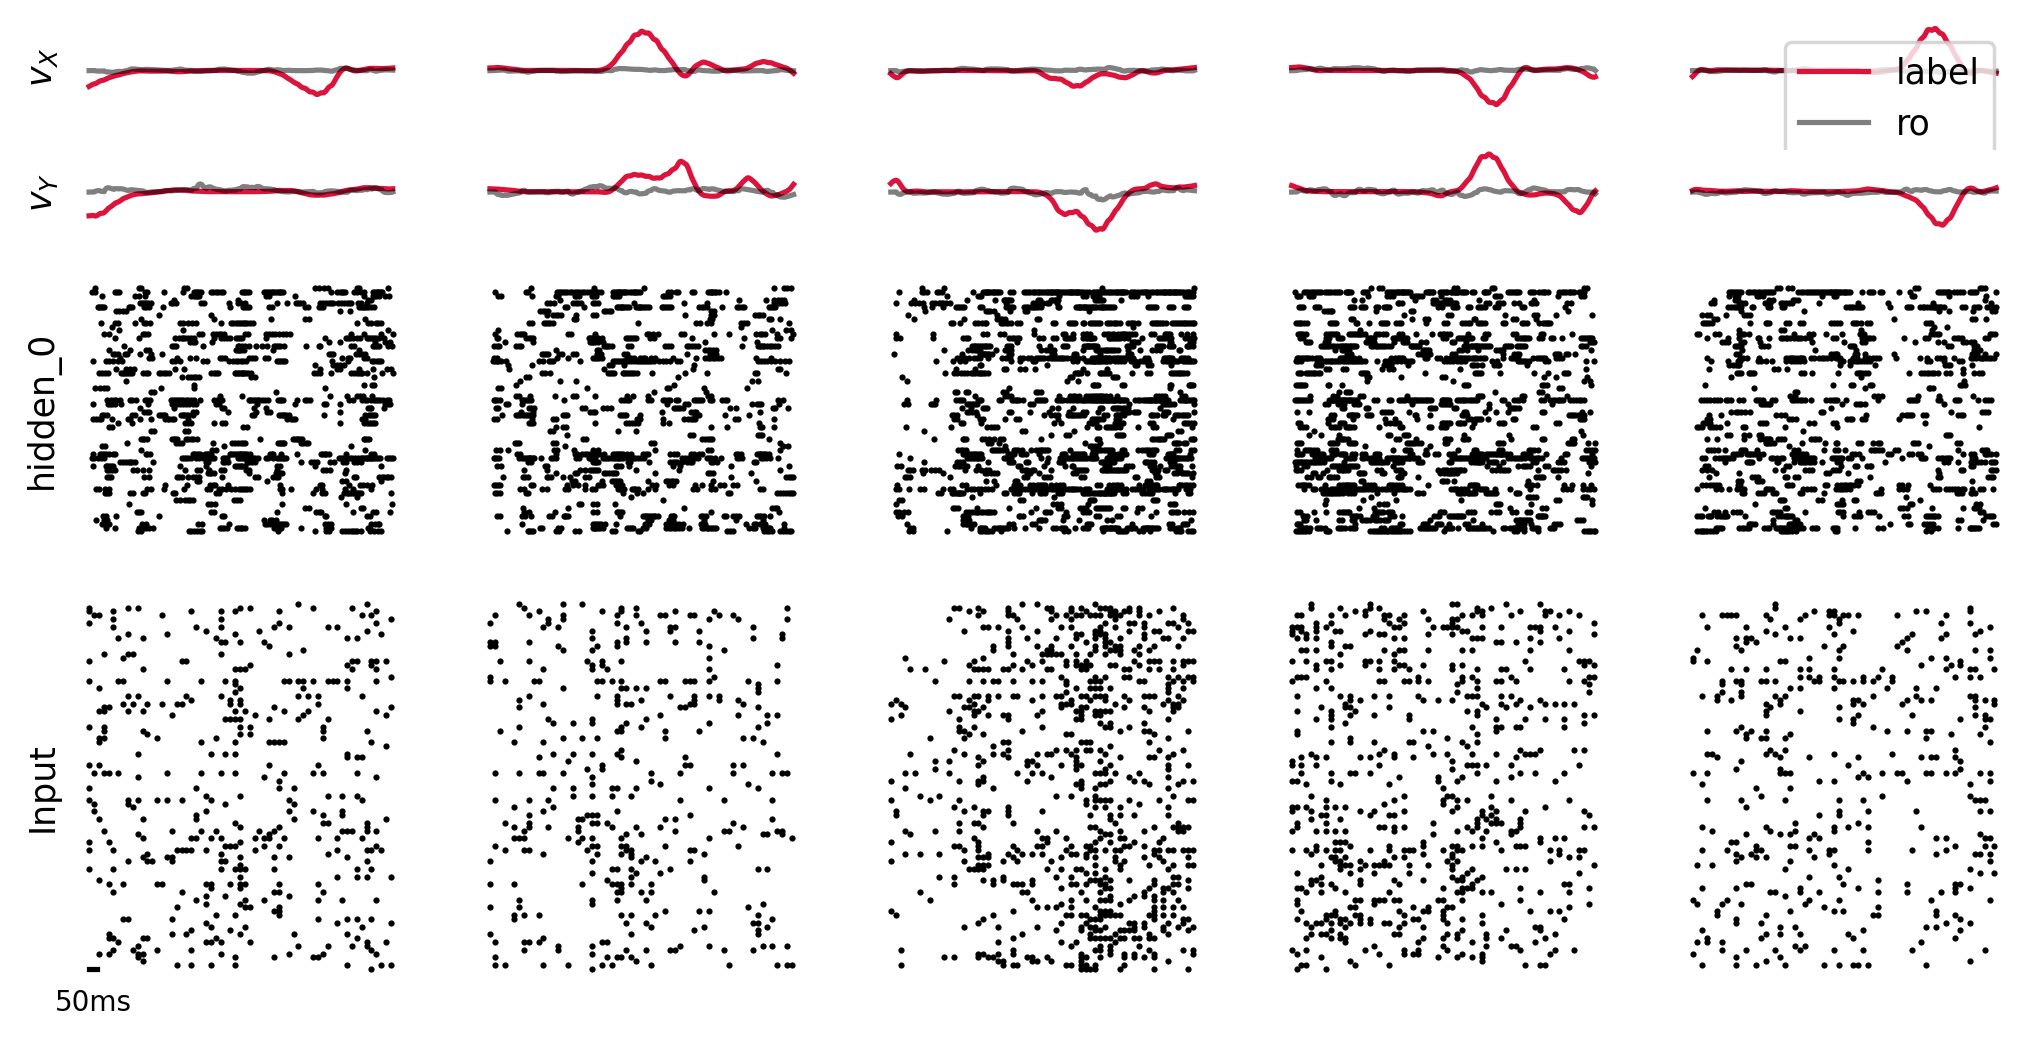

In [32]:
from datetime import datetime
from pathlib import Path
from efficient_rsnn_bmi.utils.plotting import plot_activity_snapshot

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_dir = Path("outputs") / "baseline" / timestamp

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

In [36]:
history = model.fit_validate(
    train_data,
    val_data,
    nb_epochs=5,
    verbose=True
)

Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

00  loss=0.229 reg_loss=0.000219 r2x=0.0203 r2y=0.0112 r2=0.0158 -- val_loss=0.276 val_reg_loss=5.11e-06 val_r2x=0.0257 val_r2y=0.0185 val_r2=0.022 t_iter=16.84



Evaluating: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]

01  loss=0.228 reg_loss=0.000212 r2x=0.0282 r2y=0.0171 r2=0.0225 -- val_loss=0.274 val_reg_loss=4.89e-06 val_r2x=0.04 val_r2y=0.025 val_r2=0.0323 t_iter=17.51



Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

02  loss=0.227 reg_loss=0.00025 r2x=0.0372 r2y=0.0204 r2=0.0289 -- val_loss=0.273 val_reg_loss=5.01e-06 val_r2x=0.05 val_r2y=0.0288 val_r2=0.0395 t_iter=16.98



Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

03  loss=0.226 reg_loss=0.000281 r2x=0.0465 r2y=0.0259 r2=0.0363 -- val_loss=0.271 val_reg_loss=5.28e-06 val_r2x=0.0618 val_r2y=0.0338 val_r2=0.048 t_iter=19.34



Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

04  loss=0.225 reg_loss=0.000322 r2x=0.0571 r2y=0.0299 r2=0.0434 -- val_loss=0.27 val_reg_loss=5.4e-06 val_r2x=0.074 val_r2y=0.0397 val_r2=0.057 t_iter=19.54


In [34]:
import torch
import numpy as np
import json

def to_serializable(val):
    if isinstance(val, torch.Tensor):
        return val.item() if val.numel() == 1 else val.tolist()
    elif isinstance(val, np.ndarray):
        return val.tolist()
    elif isinstance(val, (np.floating, np.integer)):
        return val.item()
    elif isinstance(val, dict):
        return {k: to_serializable(v) for k, v in val.items()}
    elif isinstance(val, list):
        return [to_serializable(v) for v in val]
    else:
        return val

In [35]:
serializable_history = to_serializable(history)

with open("training_interpolation_early_5epoch_result.json", "w") as f:
    json.dump(serializable_history, f, indent=2)

In [33]:
inp = model.input_group.get_flattened_out_sequence().detach().cpu().numpy()

# Interpolated input shape: [batch, reduced_T, units]
batch_size, reduced_T, units = inp.shape
full_T = model.nb_time_steps  # e.g., 500
n_keys = model.n_keys         # e.g., 8

# Create full-size zero-padded array
inp_padded = np.zeros((batch_size, full_T, units), dtype=inp.dtype)

# Map back the reduced timesteps (every n_keys)
for i in range(reduced_T):
    t = i * n_keys
    if t < full_T:
        inp_padded[:, t, :] = inp[:, i, :]

inp = inp_padded  # use this padded input for plotting


In [34]:
inp.shape

(224, 500, 96)

In [36]:
inp[8]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [37]:
model.input_group.get_state_sequence("out").reshape((224, 64, 96))

tensor([[[0., 0., 0.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 1., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [38]:
model.input_group.shape

(96,)

In [36]:
model.input_group.flat_seq_shape

(224, 500, 96)

In [33]:
for t in range(0, 500, 8):
    is_last = (t + 8 >= 500)
    steps_to_next = min(8, 500 - t)

In [34]:
is_last

True

In [35]:
steps_to_next

4

In [35]:
model.connections[1]

InterpolationConnection(
  (src): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (dst): CustomLIFGroup(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (op): Linear(in_features=64, out_features=64, bias=False)
)

In [ ]:

fig, ax = plot_activity_snapshot(
    model,
    val_data,
    save_path= output_dir / f"pretraining/baseline_{monkey_name}/snapshot_before.png"
)

In [ ]:
model.groups[:]

[InterpolationInputGroup(
   (dropout): Dropout(p=0.3, inplace=False)
 ),
 CustomLIFGroup(
   (dropout): Dropout(p=0.3, inplace=False)
 ),
 CustomReadoutGroup()]

In [ ]:
inputs = ["1", "2", "3", "4", "5"]

input = inputs[0]
for i in inputs[1:-1]:
    print("Testing")
    input += "2"
    print(input)
    input = i
    print(input)

Testing
12
2
Testing
22
3
Testing
32
4


In [ ]:
for input in inputs[1:-1]:
    print(input)

2
3
4


In [ ]:
history = model.fit_validate(
    train_data,
    val_data,
    nb_epochs=5,
    verbose=True
)